<a href="https://colab.research.google.com/github/HaaLeo/vague-requirements-scripts/blob/master/colab-notebooks/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify requirements as vague or not using [ktrain](https://github.com/amaiya/ktrain) and tensorflow


## Install dependencies
*ktrain* requires TensorFlow 2.1. See [amaiya/ktrain#151](https://github.com/amaiya/ktrain/issues/151).
Further we install a forked version of eli5lib to gain insights in the model's decision process and some self built helper functions to preprocess MTurk result files.

In [5]:
%load_ext google.colab.data_table
!pip3 install -q tensorflow_gpu==2.1.0 ktrain==0.17.5 imbalanced-learn==0.5.0
!pip3 install -q -U git+https://github.com/HaaLeo/vague-requirements-scripts
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Check versions and enable logging

In [4]:
import tensorflow as tf
import ktrain
import imblearn

assert tf.__version__ == '2.1.0'
assert ktrain.__version__ == '0.17.5'
assert imblearn.__version__ == '0.5.0'

import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(name)-20.20s] [%(levelname)-5.5s]  %(message)s',
    stream=sys.stdout,
    level=logging.INFO)

LOGGER = logging.getLogger('colab-notebook')
LOGGER.info('Hello from colab notebook')

2020-07-11 13:35:25,109 [colab-notebook      ] [INFO ]  Hello from colab notebook


## Set Parameters
Set the parameters for this run.
Ktrain ignores `max_features` and `ngram_range` in v0.17.5, see [amaiya/ktrain/issues#190](https://github.com/amaiya/ktrain/issues/190)

In [11]:
#@title Set the parameter and hyperparameter 
#@markdown Set data files and proportion of train, val test set in source code

def set_parameters() -> dict:
    # Lists are not yet supported as form fields
    data_file_names = [f'corpus-batch-{i}-mturk.csv' for i in range(5)] + ['corpus-batch-5-27-mturk.csv']
    test_proportion = 0.1 # Proportion of the test set of the overall data
    class_names = ['not-vague', 'vague'] # 0=not-vague 1=vague

    # The following parameter can be edited with the form fields
    random_state = 1  #@param {type:"integer"}

    resampling_strategy = 'random_downsampling'#@param ["random_downsampling", "random_upsampling"]

    kfold_splits = 10 #@param {type:"integer"}
    learning_rate = 1e-5 #@param {type:"number"}
    epochs =  1#@param {type:"integer"}
    model_name = 'distilbert-base-uncased' #@param {type:"string"}
    max_len = 256 #@param {type:"integer"}
    batch_size = 6 #@param {type:"integer"}
    max_features =  35000 #@param {type:"integer"}
    ngram_range = 1 #@param {type:"integer"}


    preprocess_mode = 'distilbert' #@param {type:"string"}

    return {
        'data_file_names': data_file_names,
        'test_proportion': test_proportion,
        'class_names': class_names,

        'random_state': random_state,

        'resampling_strategy': resampling_strategy,

        'kfold_splits': kfold_splits,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'model_name': model_name,
        'max_len': max_len,
        'batch_size': batch_size,
        'max_features': max_features,
        'ngram_range': ngram_range,

        'preprocess_mode': preprocess_mode
    }

params = set_parameters()
LOGGER.info(f'Sucessfully set parameters="{params}".')

2020-07-11 13:38:45,305 [colab-notebook      ] [INFO ]  Sucessfully set parameters="{'data_file_names': ['corpus-batch-0-mturk.csv', 'corpus-batch-1-mturk.csv', 'corpus-batch-2-mturk.csv', 'corpus-batch-3-mturk.csv', 'corpus-batch-4-mturk.csv', 'corpus-batch-5-27-mturk.csv'], 'test_proportion': 0.1, 'class_names': ['not-vague', 'vague'], 'random_state': 1, 'resampling_strategy': 'random_downsampling', 'kfold_splits': 10, 'learning_rate': 1e-05, 'epochs': 1, 'model_name': 'distilbert-base-uncased', 'max_len': 256, 'batch_size': 6, 'max_features': 35000, 'ngram_range': 1, 'preprocess_mode': 'distilbert'}".


## Load Dataset

### Mount Google Drive
Mount the google drive to access the dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load Dataset

In [9]:
from vaguerequirementslib import read_csv_files, build_confusion_matrix, calc_majority_label
import pandas as pd

def read_drive_data(files_list: list, separator: str) -> pd.DataFrame:
    """
    Calculate the majority label for the given source file list

    Args:
        files_list (list): The CSV files to calculate the majority label for
        separator (str): The CSV separator
        drop_ties (bool): If there is a tie in votes (e.g.: One votes for vague one for not vague) then drop this entry from the confusion matrix.

    Returns:
        pd.DataFrame: The dataframe containing the majority label.
    """
    frame = read_csv_files(files_list, separator)
    confusion_matrix = build_confusion_matrix(frame, drop_ties=True)
    return calc_majority_label(confusion_matrix)

# Read all data
df = read_drive_data(
    [f'/content/drive/My Drive/datasets/corpus/labeled/{file_name}' for file_name in params['data_file_names']],
    ','
  )
df_vague_count = int(df[df.majority_label == 1].majority_label.value_counts())
df_not_vague_count = int(df[df.majority_label == 0].majority_label.value_counts())
LOGGER.info(f'Data frame consists of {df_vague_count} vague data points and {df_not_vague_count} not vague data points.')
df.head()

2020-07-11 13:36:57,967 [vaguerequirementslib] [INFO ]  Build confusion matrix.
2020-07-11 13:36:58,992 [vaguerequirementslib] [INFO ]  Dropped 1228 requirements due to ties.
2020-07-11 13:36:58,996 [vaguerequirementslib] [INFO ]  Built confusion matrix including 1548 of 2776 requirements. 
2020-07-11 13:36:59,003 [vaguerequirementslib] [INFO ]  Overall "vague" votes count = 576. Overall "not vague" votes count = 2520
2020-07-11 13:36:59,103 [vaguerequirementslib] [INFO ]  "vague" majority label count = 288. "not vague" majority label count = 1260.
2020-07-11 13:36:59,113 [colab-notebook      ] [INFO ]  Data frame consists of 288 vague data points and 1260 not vague data points.


,requirement,vague_count,not_vague_count,majority_label
0,A COPV representative of the flight COPV (line...,2,0,1
1,A Charge-Through VCONN -Powered USB Device sha...,0,2,0
2,A Charge-Through VCONN-Powered USB Device shal...,0,2,0
3,A Controller that supports Directed Advertisin...,0,2,0
4,A DC voltage between 0 V and -66 V may be pres...,0,2,0


## Utility Functions

### Resample and preprocess

In [19]:
from typing import Tuple, List

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from ktrain import text as txt

def resample(data_frame: pd.DataFrame, random_state: int, resampling_strategy: str = None) -> pd.DataFrame:
    """
    Re sample the given dataframe to contain equally much samples of vague and not-vague requirements.

    Args:
        data_frame (pd.DataFrame): The data frame to upsample.
        random_state (int): For seeding results
        strategy (str): The resampling strategy to use either "random_downsampling", "random_upsampling" or None.

    Returns:
        pd.DataFrame: The resampled data frame.
    """
    if resampling_strategy:
        if resampling_strategy == 'random_downsampling':
            sampler = RandomUnderSampler(sampling_strategy=1., random_state=random_state)
        elif resampling_strategy == 'random_upsampling':
            sampler = RandomOverSampler(sampling_strategy=1., random_state=random_state)

        x, y = sampler.fit_resample(data_frame.requirement.to_numpy().reshape(-1, 1), data_frame.majority_label)
        result = pd.DataFrame({'requirement': x.flatten(), 'majority_label': y})

        LOGGER.info(f'Resampled dataset with strategy"{resampling_strategy}": vague count="{result.sum()["majority_label"]}", not vague count="{result.shape[0] - result.sum()["majority_label"]}"')
    
    else: 
        LOGGER.warning('Data frame will not be resampled, because no strategy was provided.')
        result = data_frame
    return result

def preprocess_data(data_frame: pd.DataFrame, **kwargs) -> Tuple:
    dummy_df = pd.DataFrame.from_dict({'requirement': ['foo', 'bar'], 'majority_label': [0, 1]})
    LOGGER.info(f'Preprocess the data using preprocess-mode="{kwargs["preprocess_mode"]}", max-features="{kwargs["max_features"]}", ngram-range="{kwargs["ngram_range"]}" and max-len="{kwargs["max_len"]}".')
    data, _, _ = txt.texts_from_df(
        data_frame, 
        text_column='requirement',
        label_columns=['majority_label'], 
        val_df=dummy_df,  
        max_features=kwargs['max_features'],
        maxlen=kwargs['max_len'],  
        ngram_range=kwargs['ngram_range'],
        preprocess_mode=kwargs['preprocess_mode'],
        random_state=kwargs['random_state'])
    
    return data

### Create result object

Gather results, calulate metrics.

In [22]:
import os
import json
from os import path

from vaguerequirementslib import TP, TN, FP, FN, calc_all_metrics

def build_fold_result(train_result, val_result, test_result, learning_history) -> dict:
    fold_result = {
        'metrics':{
            'train': {
                'vague': {
                    TP: int(train_result[1][1]),
                    FP: int(train_result[0][1]),
                    TN: int(train_result[0][0]),
                    FN: int(train_result[1][0])
                },
                'not_vague': {
                    TP: int(train_result[0][0]),
                    FP: int(train_result[1][0]),
                    TN: int(train_result[1][1]),
                    FN: int(train_result[0][1])
                }
            },
            'validation': {
                'vague': {
                    TP: int(val_result[1][1]),
                    FP: int(val_result[0][1]),
                    TN: int(val_result[0][0]),
                    FN: int(val_result[1][0])
                },
                'not_vague': {
                    TP: int(val_result[0][0]),
                    FP: int(val_result[1][0]),
                    TN: int(val_result[1][1]),
                    FN: int(val_result[0][1])
                }
            },
            'test': {
                'vague': {
                    TP: int(test_result[1][1]),
                    FP: int(test_result[0][1]),
                    TN: int(test_result[0][0]),
                    FN: int(test_result[1][0])
                },
                'not_vague': {
                    TP: int(test_result[0][0]),
                    FP: int(test_result[1][0]),
                    TN: int(test_result[1][1]),
                    FN: int(test_result[0][1])
                }
            }
        },
        'learning_history': learning_history
    }
    for key in fold_result['metrics']:
        fold_result['metrics'][key]['not_vague'].update(calc_all_metrics(**fold_result['metrics'][key]['not_vague']))
        fold_result['metrics'][key]['vague'].update(calc_all_metrics(**fold_result['metrics'][key]['vague']))

    LOGGER.debug('Successfully built fold result.')

    return fold_result


def build_result_data(fold_results: List, df_vague_count, df_not_vague_count, test_df_vague_count, test_df_not_vague_count, **kwargs) -> dict:
    result_data = {
        'misc': {   
            'random_state': kwargs['random_state']
        },
        'data_set':{
            'summary': {
                'data_files': kwargs['data_file_names'],
                'vague_data_points': df_vague_count,
                'not_vague_data_points': df_not_vague_count,
            },
            'test': {
                'proportion': kwargs['test_proportion'],
                'vague_data_points': test_df_vague_count,
                'not_vague_data_points': test_df_not_vague_count
            }
        },
        'fold_results': fold_results,
        'hyperparameter': {
            'learning_rate': kwargs['learning_rate'],
            'epochs': kwargs['epochs'],
            'model_name': kwargs['model_name'],
            'max_len': kwargs['max_len'],
            'batch_size': kwargs['batch_size'],
            'max_features': kwargs['max_features'],
            'ngram_range': kwargs['ngram_range'],
        }
    }

    LOGGER.debug('Successfully built result.')
    return result_data

### Save evaluation result

In [26]:
import os
import numpy as np


def save_evaluation_result(result_data: dict, directory:str) -> None:
    class NumpyJSONEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return super(NumpyJSONEncoder, self).default(obj)

    # Save the evaluation result (test_data results)
    os.makedirs(directory, exist_ok=True)
    with open(path.join(directory, 'evaluation.json'), mode='w', encoding='utf-8') as json_file:
        json.dump(result_data, json_file, indent=4, cls=NumpyJSONEncoder)
    LOGGER.info(f'Successfully saved evaluation result data to directory="{directory}".')

### K-Fold Cross Validation

In [24]:
from sklearn.model_selection import StratifiedKFold, train_test_split

def perform_kfold_cross_validation(model, kfold_df, test_data, **kwargs):
    fold_results = []

    fold_counter = 1
    # Cerate k folds
    kfold = StratifiedKFold(n_splits=kwargs['kfold_splits'], shuffle=True, random_state=kwargs['random_state'])
    for train_idx, val_idx in kfold.split(kfold_df.requirement, kfold_df.majority_label):
        LOGGER.info(f'\n######################\n### Process fold {fold_counter} / {kwargs["kfold_splits"]}\n######################')

        # Get training data and validation data for this fold
        train_df = kfold_df.iloc[train_idx]
        val_df = kfold_df.iloc[val_idx]
        LOGGER.info(f'Training dataset: vague count="{int(train_df[train_df.majority_label == 1].majority_label.value_counts())}", not vague count="{int(train_df[train_df.majority_label == 0].majority_label.value_counts())}".')
        LOGGER.info(f'Validation dataset: vague count="{int(val_df[val_df.majority_label == 1].majority_label.value_counts())}", not vague count="{int(val_df[val_df.majority_label == 0].majority_label.value_counts())}".')
        
        # Resample train df 
        LOGGER.info('Resample training data set.')
        train_df = resample(train_df, kwargs['random_state'], kwargs['resampling_strategy'])

        LOGGER.info(f'Preprocess training and validation data for the model="{kwargs["model_name"]}".')
        train_data = preprocess_data(train_df, **kwargs)
        val_data = preprocess_data(val_df, **kwargs)

        # Get the learner for the new fold
        LOGGER.info('Fit the model for one cycle.')
        learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=kwargs['batch_size'])

        # Fit the model
        learning_history = learner.fit_onecycle(kwargs['learning_rate'], kwargs['epochs']).history
        learner.plot('loss')

        # Evaluate the model
        train_result = learner.validate(class_names=kwargs['class_names'], val_data=train_data, print_report=False)
        val_result = learner.validate(class_names=kwargs['class_names'], val_data=val_data, print_report=False)
        test_result = learner.validate(class_names=kwargs['class_names'], val_data=test_data)

        # build fold result
        fold_result = build_fold_result(train_result, val_result, test_result, learning_history)
        fold_results.append(fold_result)

        fold_counter += 1

    LOGGER.info('Successfully trained model.')

    # Build evaluation result
    evaluation_result = build_result_data(fold_results, df_vague_count, df_not_vague_count, test_df_vague_count, test_df_not_vague_count, **kwargs)
    return evaluation_result, learner.model

## STEP 1:  Training

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

### Create a Transformer Model and Train it

In [28]:
from datetime import datetime
from pytz import timezone

# Create the transformer
t = txt.Transformer(params['model_name'], maxlen=params['max_len'], class_names=params['class_names'])
t.preprocess_train_called = True # Simulate call to preprocess_train()

# Get the model and learner
model = t.get_classifier()

# Find a suitable learning rate
# learner.lr_find(show_plot=True, start_lr=1e-09, max_epochs=EPOCHS)
# print(learner.lr_estimate())

# For every triggered fitting run create a new directory where the results will be saved
now = datetime.now(timezone('Europe/Berlin'))
result_dir = f'/content/drive/My Drive/runs/{now.strftime("%Y-%m-%d/%H-%M-%S")}'

# Split data for k-folds and test data
kfold_df, test_df = train_test_split(df, test_size=params['test_proportion'], random_state=params['random_state'], stratify=df['majority_label'])

test_df_vague_count = int(test_df[test_df.majority_label == 1].majority_label.value_counts())
test_df_not_vague_count = int(test_df[test_df.majority_label == 0].majority_label.value_counts())
LOGGER.info(f'Test dataset: vague count="{test_df_vague_count}", not vague count="{test_df_not_vague_count}"')

# Preprocess test data
test_data = preprocess_data(test_df, **params)

# Perform k fold cross validation
eval_result, trained_model = perform_kfold_cross_validation(model, kfold_df, test_data, **params)

# Save the evaluation result
save_evaluation_result(eval_result, result_dir)

predictor = ktrain.get_predictor(trained_model, preproc=t)

2020-07-11 14:11:42,492 [colab-notebook      ] [INFO ]  Test dataset: vague count="29", not vague count="126"
2020-07-11 14:11:42,494 [colab-notebook      ] [INFO ]  Preprocess the data using preprocess-mode="distilbert", max-features="35000", ngram-range="1" and max-len="256".
preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 43
	99percentile : 59


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


2020-07-11 14:11:43,601 [colab-notebook      ] [INFO ]  Successfully saved evaluation result data to directory="/content/drive/My Drive/runs/2020-07-11/16-11-42".


## STEP 2: Evaluate the model
Evaluate the model using the `test_data`.

2020-07-10 15:41:33,082 [colab-notebook      ] [INFO ]  Successfully saved evaluation result data to directory="/content/drive/My Drive/runs/2020-07-10/17-31-40".
              precision    recall  f1-score   support

   not-vague       0.85      0.79      0.82       126
       vague       0.32      0.41      0.36        29

    accuracy                           0.72       155
   macro avg       0.59      0.60      0.59       155
weighted avg       0.75      0.72      0.74       155

[[100  26]
 [ 17  12]]


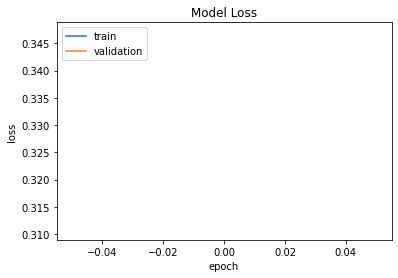

2020-07-10 15:41:40,088 [colab-notebook      ] [INFO ]  Successfully validated test set.


In [ ]:
test_result = learner.validate(class_names=params['class_names'], val_data=test_data)
print(test_result)
learner.plot('loss')
LOGGER.info('Successfully validated test set.')

## STEP 3.1 Save the predictor
Check out the [FAQ](https://github.com/amaiya/ktrain/blob/master/FAQ.md#method-1-using-predictor-api-works-for-any-model) for how to load a model from a predictor.

In [ ]:
from os import path

# Save the corresponding model (predictor)
predictor.save(path.join(result_dir, 'predictor'))

2020-07-07 20:06:38,977 [colab-notebook      ] [INFO ]  Successfully saved result data to directory="/content/drive/My Drive/runs/2020-07-07/21-56-22".


## STEP 4 Inspect the Model and its Losses

Let's examine the validation example about which we were the most wrong.

In [ ]:
learner.view_top_losses(n=4, preproc=t, val_data=test_data)
top_losses = learner.top_losses(n=4, preproc=t, val_data=test_data)

----------
id:16 | loss:1.26 | true:not-vague | pred:vague)

----------
id:22 | loss:1.2 | true:not-vague | pred:vague)

----------
id:12 | loss:1.18 | true:not-vague | pred:vague)

----------
id:8 | loss:0.99 | true:vague | pred:not-vague)



In [ ]:
top_loss_req = test_df.iloc[16]['requirement'] # Requirement that produces top loss

print(predictor.predict(top_loss_req))

# predicted probability scores for each category
print(predictor.predict_proba(top_loss_req))
print(top_loss_req)

2020-07-07 07:56:25,775 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-07 07:56:26,194 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0


vague


[0.28304783 0.71695215]
The developer shall establish, control, and maintain a software test environment to perform integration and qualification testing of software.


Let's invoke the `explain` method to see which words contribute most to the classification.

In [ ]:
from IPython.core.display import display

for id, _, _, _ in top_losses:
    top_loss_req = test_df.iloc[id]['requirement'] # Requirement that produces top loss
    display(predictor.explain(top_loss_req, n_samples=1_000))

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.